In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

In [2]:
env = gym.make('FrozenLake-v0')

In [15]:
Q = np.zeros([env.observation_space.n, env.action_space.n]) # Q table 생성!

In [20]:
learning_rate = .75
dis = .99
num_episodes = 2000

0.5075
[[6.49751331e-01 4.68968405e-03 3.09179137e-02 3.72378146e-02]
 [1.00247939e-02 2.80063062e-02 5.73646369e-04 3.52880506e-01]
 [2.32366584e-03 2.43269812e-03 1.28994514e-02 3.75365460e-01]
 [1.33273676e-03 1.10948014e-04 2.10403611e-02 4.15654695e-01]
 [5.59572326e-01 1.38923602e-04 1.60609449e-02 1.46699343e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.63740084e-02 7.40244876e-05 3.41871313e-05 4.03825840e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.03060064e-04 1.67853886e-04 7.17959873e-05 7.41804848e-01]
 [1.26803233e-03 3.44241104e-01 8.98385808e-04 2.33574167e-03]
 [8.06720836e-01 2.70914177e-04 2.43631690e-04 2.43406877e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.32077338e-03 1.47769372e-04 9.05371664e-01 8.01948120e-04]
 [7.47989364e-03 2.92058417e-04 9.55966198e-01 2.21930800e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0

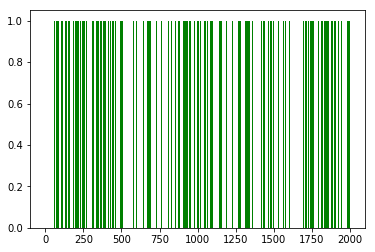

In [21]:
rList = []
for i in range(num_episodes):
    state = env.reset()
    rAll = 0
    done = False
    while not done:
        action = np.argmax(Q[state, :] + np.random.randn(1,env.action_space.n)/(i+1))
        new_state, reward, done, _ = env.step(action)
        Q[state,action] = (1-learning_rate) * Q[state,action] \
        + learning_rate * (reward + dis*np.max(Q[new_state,:])) # 고집 + 새로운 갱신
        rAll += reward
        state = new_state
    rList.append(rAll)
print(sum(rList)/num_episodes)
print(Q)
plt.bar(range(len(rList)), rList, color='green')
plt.show()

# Bandit을 해봅시다

In [22]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np

In [24]:
# 손잡이 : 4개, 밴딧(슬롯머신) : 3대
# 각각의 밴딧은 각각의 손잡이에 대해 서로 다른 성공 확률 가짐
# 최고의 결과를 얻어내기 위한 동작
# 최고 결과 주는 손잡이를 항상 선택하도록 하는 방법을 학습

In [56]:
class contextual_bandit():#밴딧 클래스
    def __init__(self): #태어나는 아기(객체)
        self.state=0    #슬롯머신 상태,아기의 몸무게(속성)
        self.bandits=np.array([[0.2,0,-0.1,-5],[0.1,-5,1,0.25],[-5,5,5,5]]) #슬롯머신(밴딧) 3대
        self.num_bandits=self.bandits.shape[0]
        self.num_actions=self.bandits.shape[1]
    def getBandit(self):
        self.state=np.random.randint(0,len(self.bandits))
        return self.state
    def pullArm(self, action):#action:레버(4개의 레버중에서 당긴 레버의 번호)
        bandit=self.bandits[self.state, action]
        result=np.random.randn(1)
        if result>bandit:
            return 1
        else:
            return -1

In [57]:
class agent(): #에이전트
    def __init__(self, lr, s_size, a_size):
        #에이전트 초기화
        self.state_in=tf.placeholder(shape=[1], dtype=tf.int32)
        state_in_OH=slim.one_hot_encoding(self.state_in, s_size)
        output=slim.fully_connected(state_in_OH, a_size, biases_initializer=None, activation_fn=tf.nn.sigmoid, weights_initializer=tf.ones_initializer())
        self.output=tf.reshape(output,[-1])
        self.chosen_action=tf.argmax(self.output,0)
        
        self.reward_holder=tf.placeholder(shape=[1], dtype=tf.float32)
        self.action_holder=tf.placeholder(shape=[1], dtype=tf.int32)
        self.responsible_weight=tf.slice(self.output,self.action_holder, [1])
        self.loss=-(tf.log(self.responsible_weight)*self.reward_holder)
        optimizer=tf.train.GradientDescentOptimizer(learning_rate=lr)
        self.update=optimizer.minimize(self.loss)    

In [48]:
nnet_inputs=tf.placeholder(tf.float32,[None,None,None,1])
net_outputs=tf.placeholder(tf.float32,[None,None,None,1])

#1번째 계층
w=tf.Variable(tf.random_normal([11,11,1,10]))
b=tf.Variable(tf.random_normal([10]))
net=tf.nn.conv2d(net_inputs, filter=w, strides=[1,4,4,1], padding='SAME')
net=tf.nn.bias_add(net,b)
net=tf.nn.relu(net)

w=tf.Variable(tf.random_normal([5,5,10,20]))
#2번째 계층
net=tf.nn.conv2d(net, filter=w, strides=[1,2,2,1], padding='SAME')
net=tf.nn.relu(net)

#3번째 계층
w=tf.Variable(tf.random_normal([3,3, 20,50]))
net=tf.nn.conv2d(net, filter=w, strides=[1,2,2,1], padding='SAME')
net=tf.nn.relu(net)

In [49]:
tf.trainable_variables()

[<tf.Variable 'fully_connected/weights:0' shape=(3, 4) dtype=float32_ref>,
 <tf.Variable 'Variable:0' shape=(11, 11, 1, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(5, 5, 10, 20) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(3, 3, 20, 50) dtype=float32_ref>]

In [50]:
train_var = [var for var in tf.trainable_variables()]
for tv in train_var:
    print(tv)

<tf.Variable 'fully_connected/weights:0' shape=(3, 4) dtype=float32_ref>
<tf.Variable 'Variable:0' shape=(11, 11, 1, 10) dtype=float32_ref>
<tf.Variable 'Variable_1:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'Variable_2:0' shape=(5, 5, 10, 20) dtype=float32_ref>
<tf.Variable 'Variable_3:0' shape=(3, 3, 20, 50) dtype=float32_ref>


In [58]:
#학습
tf.reset_default_graph()
cBandit=contextual_bandit() #객체 생성
myAgent=agent(lr=0.001,s_size=cBandit.num_bandits, a_size=cBandit.num_actions) #객체 생성
weights=tf.trainable_variables()[0]

total_episodes=10000
total_reward=np.zeros([cBandit.num_bandits, cBandit.num_actions])
e=0.1
init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    i=0
    while i < total_episodes:
        s=cBandit.getBandit()
        
        if np.random.rand(1)<e: #exploration
            action=np.random.randint(cBandit.num_actions)
        else:  #exploit
            action=sess.run(myAgent.chosen_action,feed_dict={myAgent.state_in:[s]})
        
        reward=cBandit.pullArm(action)
        
        #네트워크 업데이트
        feed_dict={myAgent.reward_holder:[reward],myAgent.action_holder:[action],myAgent.state_in:[s]}
        _, ww=sess.run([myAgent.update, weights], feed_dict=feed_dict)
        
        total_reward[s,action]+=reward
        
        if i%500==0:
            print("각 보상의 평균 : "+str(cBandit.num_bandits)+" 밴딧:"+str(np.mean(total_reward,axis=1)))
        i+=1
        

각 보상의 평균 : 3 밴딧:[ 0.   -0.25  0.  ]
각 보상의 평균 : 3 밴딧:[32.5  43.5  37.25]
각 보상의 평균 : 3 밴딧:[72.75 80.   78.5 ]
각 보상의 평균 : 3 밴딧:[108.   118.   114.75]
각 보상의 평균 : 3 밴딧:[148.5  160.5  148.75]
각 보상의 평균 : 3 밴딧:[191.75 197.25 181.75]
각 보상의 평균 : 3 밴딧:[228.   233.   222.25]
각 보상의 평균 : 3 밴딧:[267.   270.25 261.5 ]
각 보상의 평균 : 3 밴딧:[305.25 306.75 296.25]
각 보상의 평균 : 3 밴딧:[340.25 347.   328.5 ]
각 보상의 평균 : 3 밴딧:[378.25 385.5  366.  ]
각 보상의 평균 : 3 밴딧:[414.   425.25 401.5 ]
각 보상의 평균 : 3 밴딧:[453.5  467.25 436.5 ]
각 보상의 평균 : 3 밴딧:[493.75 509.   464.  ]
각 보상의 평균 : 3 밴딧:[533.5  544.5  496.25]
각 보상의 평균 : 3 밴딧:[575.25 579.5  533.5 ]
각 보상의 평균 : 3 밴딧:[616.25 613.   568.  ]
각 보상의 평균 : 3 밴딧:[652.25 658.5  599.5 ]
각 보상의 평균 : 3 밴딧:[692.25 695.5  632.5 ]
각 보상의 평균 : 3 밴딧:[733.   730.25 668.5 ]
